# Sprint　機械学習スクラッチ　クラスタリング  
＜目的＞  
- スクラッチを通してK-meansを理解する
- クラスタ分析を行う

K-meansのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

＜クラスタリングのための人工データセット＞  
クラスタリングを実験するための人工データセットを作成するコードを用意しています。  
このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 **_（アンダースコア）** で受け取っています。

X size : (100, 2)
< X scatter >


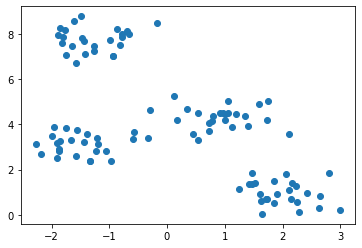

In [3]:
# データセット読み込み
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
print('X size :',X.shape)
print('< X scatter >')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

### 【問題1】中心点の初期値を決める  
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。  
最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。  
K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。  

### 【問題2】SSEを求める関数の作成  
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。  
K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。  

$$
SSE=\sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}\|X_n-\mu_k\|^2
$$

$n$ : データ点のインデックス  
$k$ : クラスタのインデックス  
$X_n$ : $n$番目のデータ点  
$\mu_k$ : $k$番目の中心点  
$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

＜クラスタの割り当てと中心点の移動を繰り返す＞  
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。  
中心点 $\mu_k$ を固定した上で $SSE$ を最小化する クラスタの割り当て $r_{nk}$ を選ぶ。  
クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。  
最初の中心点 $\mu_k$ は問題1で作成した初期値です。

### 【問題3】クラスタへの割り当て  
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。  
K-menasにおける **近い** とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。

$$
\|q-p\|=\sqrt{(q-p)\cdot(q-p)}
$$

NumPyにはこの関数が``np.linalg.norm``として用意されているため使用してください。  
中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【問題4】中心点の移動  
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。  
クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【問題5】繰り返し    
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  
次のどれかの条件を満たしたらこれを止めます。  
- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
- 中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

### 【問題6】異なる初期値で計算    
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。  
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。

### 【問題7】推定  
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  
- データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。  

具体的には次のことです。  

- データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance
from matplotlib import cm
import pandas as pd
from sklearn.decomposition import PCA
from IPython.display import Image
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [4]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
    
    # 問題１　中心点の初期値
    def _init_centroids(self, X):
        indices = np.random.choice(np.arange(X.shape[0]), self.n_clusters, replace=False)
        return X[indices, :]
    
    # 問題２　SSEを求める関数
    # |X-μ|^2 = |X|^2 + |μ|^2 - 2X・μの関係を利用
    def SSE(self, X, mu, R):
        m = X.shape[0]
        k = mu.shape[0] 
        X_2 = np.sum(X**2, axis=1)[:, np.newaxis]
        mu_2 = np.sum(mu**2, axis=1)
        # X|^2 , |μ|^2を並べる
        XX = np.tile(X_2, (1, k))
        mumu = np.tile(mu_2, (m, 1))
        # 両者を加え、2X・μを引く
        Z = XX + mumu - 2*(X@mu.T)
        # クラス判別行列Rをかけて出力
        return sum(sum(Z*R))   
    
    # 問題３　クラスタへの割り当て
    def _grouping(self, X, mu):
        assign = []
        for i in range(X.shape[0]):
            norm = []
            for j in range(mu.shape[0]):
                # 各中心点との距離を計算し格納
                d = np.linalg.norm((X[i] - mu[j]), ord=2)
                norm.append(d)
            # 距離が最小の場所へ割り当てる
            assign.append(np.argmin(norm))
        # labelからone-hotに変換して出力
        return np.eye(self.n_clusters)[assign]
    
    # 問題４　中心点の移動
    def _move_centroids(self, X, mu, R):
        # 各クラスタのサンプル数行列を生成
        count_group = np.sum(R, axis=0)[:, np.newaxis]
        count_group_matrix = np.tile(count_group, (1, X.shape[1]))
        # 該当するクラスのサンプル総和を、サンプル数で割り出力
        return (R.T@X)/count_group_matrix
    
    # 学習の推移を散布図で出力
    def _plot_cluster(self, X, mu, R):
        for i in range(mu.shape[0]):
            # 該当するクラスを取り出してプロット
            X_i = X[R[:, i]==1]
            plt.scatter(X_i[:, 0], X_i[:, 1], label=i)
        for j in range(mu.shape[0]):
            # 該当する重心をプロット
            plt.scatter(mu[j, 0], mu[j, 1], color='black', marker='x')
        plt.show()
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        self.centroids = []
        self.SSEs = []
        
        # 問題５　繰り返し
        # 問題６　異なる初期値で計算
        # n_init数だけ初期値を変え、epocを繰り返す
        for j in range(self.n_init):
            if self.verbose:
                #verboseをTrueにした際はepoc数を出力
                print('< epoc : {} >'.format(j+1))
            mu = self._init_centroids(X)
            centroids = [mu]
            for i in range(self.max_iter):
                R = self._grouping(X, mu)
                mu = self._move_centroids(X, mu, R)
                # 重心変化の絶対値のうち、最大のものが閾値より小さいとき終了
                if np.amax(np.abs(mu - centroids[-1])) <= self.tol:
                    # 終了時の重心とSSEを格納
                    self.centroids.append(mu)
                    self.SSEs.append(self.SSE(X, mu, R))
                    break
                else:
                    centroids.append(mu)
                    # 繰り返しの最大値のとき終了
                    if i == self.max_iter-1:
                        # 終了時の重心とSSEを格納
                        self.centroids.append(mu)
                        self.SSEs.append(self.SSE(X, mu, R))
                    if self.verbose:
                        #verboseをTrueにした際は過程の散布図も出力
                        print('iteration :', i+1)
                        self._plot_cluster(X, mu, R)
                    
            if self.verbose:
                #verboseをTrueにした際は終了時の重心とSSEも出力
                print('centroids :', self.centroids[-1])
                print('SSE :', self.SSEs[-1])

    # 問題７　推定
    # 複数epocの場合は、epocを指定できるようにする
    def predict(self, X, epoc):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        mu = self.centroids[epoc-1]
        # 指定したepocの最終重心と割り当て行列を出力する形にした
        return mu, self._grouping(X, mu)

< epoc : 1 >
iteration : 1


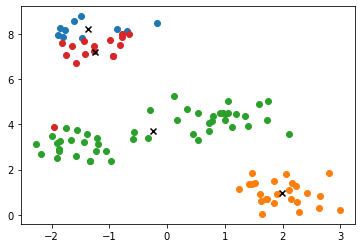

iteration : 2


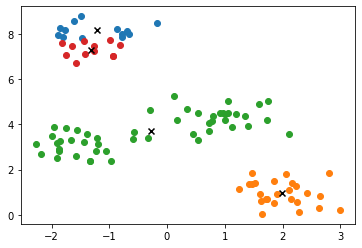

iteration : 3


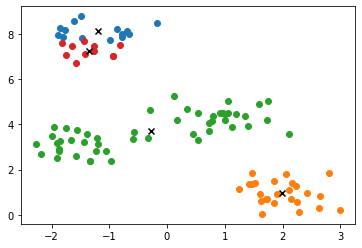

centroids : [[-1.20303343  8.14625181]
 [ 1.99186903  0.96561071]
 [-0.27678616  3.72096344]
 [-1.35095137  7.27700373]]
SSE : 134.38175056942373
< epoc : 2 >
iteration : 1


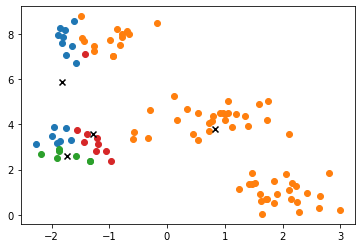

iteration : 2


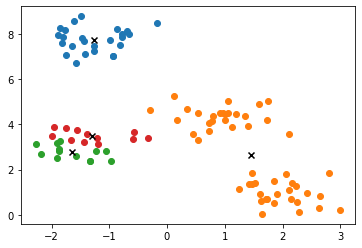

iteration : 3


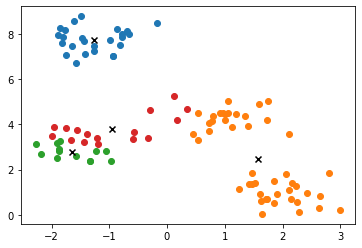

iteration : 4


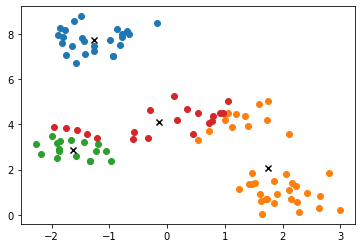

iteration : 5


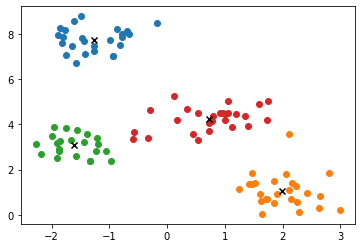

centroids : [[-1.26811733  7.76378266]
 [ 1.99645666  1.06603355]
 [-1.61318321  3.06863899]
 [ 0.72368797  4.25783369]]
SSE : 56.556212971528865


In [5]:
# Scratchで学習
skm = ScratchKMeans(n_clusters=4, 
                    n_init=2, 
                    max_iter=5, 
                    tol=1e-5,
                    verbose=True)
skm.fit(X)

- 指定したepoc数、iteration数で学習できている
- 重心の移動をみると、挙動は適切のようだ
- epoc 2の学習が適切なので、これを出力できるか確認する

In [6]:
# クラスタ出力確認のための散布図描画関数
def plot_cluster(X, mu, R, xlabel=None, ylabel=None, title=None):
    for i in range(mu.shape[0]):
        X_i = X[R[:, i]==1]
        plt.scatter(X_i[:, 0], X_i[:, 1], label=i, alpha=0.5)
    for j in range(mu.shape[0]):
        plt.scatter(mu[j, 0], mu[j, 1], color='black', marker='x')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()

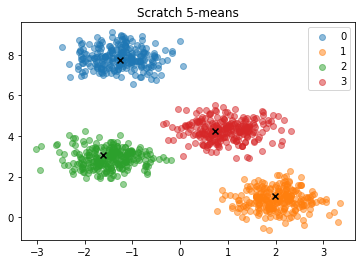

In [8]:
# 新たにデータセット読み込み（1000サンプル）
X_1, _ = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

# 学習モデル（epoc:2）で予測し散布図描画
mu, R = skm.predict(X_1, epoc=2)
plot_cluster(X_1, mu, R, title='Scratch 5-means')

- 結果はpredict()メソッドで再現できている

### 【問題8】エルボー法の実装  
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。  
SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [9]:
# エルボー法の関数化
# 検証するクラスタ数を引数として渡す
def elbow_view(X, n_clusters, max_iter, title):
    SSEs = []
    for i in range(2, n_clusters+1):
        skm = ScratchKMeans(n_clusters=i, 
                            n_init=1, 
                            max_iter=max_iter, 
                            tol=1e-5, 
                            verbose=False)
        skm.fit(X)
        SSEs.append(skm.SSEs[-1])
    
    plt.title(title)
    plt.plot(np.arange(2, n_clusters+1), SSEs)
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

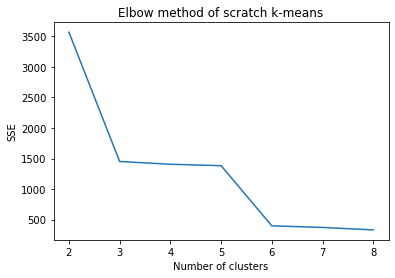

In [10]:
elbow_view(X, n_clusters=8, max_iter=10, title='Elbow method of scratch k-means')

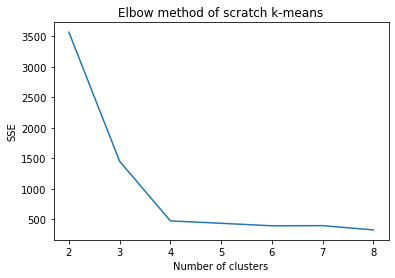

In [11]:
elbow_view(X, n_clusters=8, max_iter=10, title='Elbow method of scratch k-means')

- 重心の初期値により結果が異なるが、大体は 4 が変曲点のようだ

### 【問題9】シルエット図  
$k$ を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。  
Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。  

``silhouette_vals`` : shape(n_samples,)のndarray、各データ点のシルエット係数  
``silhouette_avg`` : float、シルエット係数の平均値  
``y_km`` : shape(n_samples,)のndarray、各データ点のクラスタラベル名  
``cluster_labels`` : list、クラスタのラベル名のリスト  
``n_clusters`` : int、クラスタ数  

$n$ 番目のデータ点に対するシルエット係数 $s_n$ は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$$
s_n=\frac{b_n-a_n}{max(b_n, a_n)}
$$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。  
$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。  

乖離度 $b$ が大きく、凝集度 $a$ が小さい時が理想的であり、シルエット係数 $s$ は1に近くなります。

In [12]:
# シルエット図描画の関数化
def silhouette_view(X, n_clusters, max_iter):
    # 指定したクラス数までシルエット図を描画
    for i in range(2, n_clusters+1):
        print('< {} clusters >'.format(i))
        skm = ScratchKMeans(n_clusters=i, 
                            n_init=1, 
                            max_iter=max_iter, 
                            tol=1e-5, 
                            verbose=False)
        skm.fit(X)
        # 初期値は1通りのみ（epoc=1）
        mu, R = skm.predict(X, epoc=1)
        # SSEで用いた手法は煩雑なので、scipyの距離行列を用いる
        dist_mu = distance.cdist(mu, mu, metric='euclidean')
        # 距離=0のところは最大値で置き換える
        d = np.where(dist_mu == 0, np.amax(dist_mu), dist_mu)
        # a_n, b_nを初期化
        a_n = np.zeros(X.shape[0])
        b_n = np.zeros(X.shape[0])
        for i in range(mu.shape[0]):
            # 該当するクラスサンプルを取得
            indices_a = np.where(R[:, i]==1)[0]
            X_a = X[indices_a]
            # 編集した距離行列を参照し、距離が最小のクラスサンプルを取得
            near = np.argmin(d[i])
            indices_b = np.where(R[:, near]==1)[0]
            X_b = X[indices_b]
            # 距離行列の行方向で平均値を算出
            mean_dist_aa = np.mean(distance.cdist(X_a, X_a, metric='euclidean'), axis=1)
            mean_dist_ab = np.mean(distance.cdist(X_a, X_b, metric='euclidean'), axis=1)
            # クラスサンプル数分、該当するインデックスのa_n, b_nを更新
            for j in range(X_a.shape[0]):
                a_n[indices_a[j]] = mean_dist_aa[j]
                b_n[indices_a[j]] = mean_dist_ab[j]
        
        # 定義に従い、与える数値を計算
        max_ab = np.maximum(a_n, b_n)
        silhouette_vals = (b_n - a_n)/max_ab
        silhouette_avg = np.mean(silhouette_vals)
        # one-hot行列からlabelへデコード
        y_km = np.argmax(R, axis=1)
        cluster_labels = np.arange(R.shape[1])
        n_clusters = R.shape[1]
        
        # シルエット図表示コード
        y_ax_lower, y_ax_upper = 0, 0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(i / n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
            yticks.append((y_ax_lower + y_ax_upper) / 2)
            y_ax_lower += len(c_silhouette_vals)
        plt.axvline(silhouette_avg, color="red", linestyle="--")
        plt.yticks(yticks, cluster_labels + 1)
        plt.ylabel('Cluster')
        plt.xlabel('Silhouette coefficient')
        plt.show()

< Silhouette view of scratch k-means>
< 2 clusters >


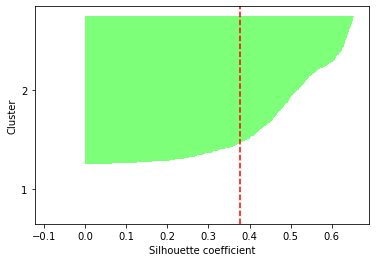

< 3 clusters >


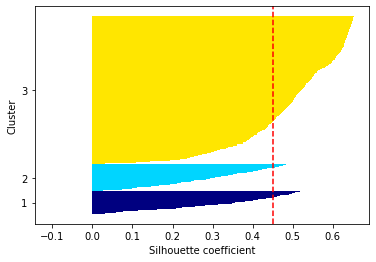

< 4 clusters >


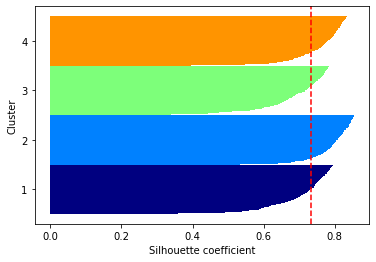

< 5 clusters >


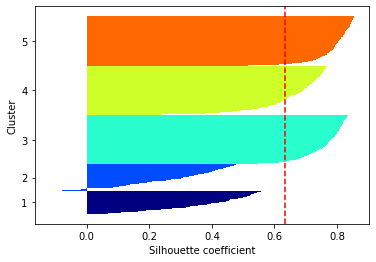

< 6 clusters >


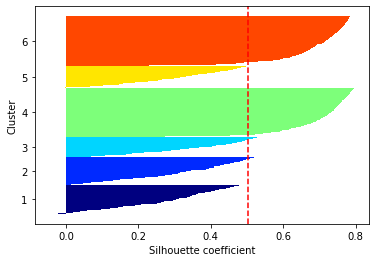

In [13]:
# スクラッチ学習で表示
print('< Silhouette view of scratch k-means>')
silhouette_view(X, n_clusters=6, max_iter=10)

- シルエット図からも、クラス数 4 が適切にみえる

### ＜クラスタ分析＞  
＜卸売業者のデータ分析＞  
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。  

``UCI Machine Learning Repository: Wholesale customers Data Set``

Data Folderの中から``Wholesale customers data.csv``をダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。``Region``と``Channel``は取り覗き、金額のデータでK-meansを利用します。


＜次元削減＞  
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [14]:
# データのロード
df = pd.read_csv('Wholesale customers data.csv')
display(df.head())
display(df.info())
print('size : ', np.shape(df))

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


None

size :  (440, 8)


In [15]:
# 金額データのみ抽出
data = df.iloc[:, 2:].values
data[:5]

array([[12669,  9656,  7561,   214,  2674,  1338],
       [ 7057,  9810,  9568,  1762,  3293,  1776],
       [ 6353,  8808,  7684,  2405,  3516,  7844],
       [13265,  1196,  4221,  6404,   507,  1788],
       [22615,  5410,  7198,  3915,  1777,  5185]], dtype=int64)

In [16]:
# PCAを用いて次元削減
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
data_pca[:5]

array([[  650.02212207,  1585.51909007],
       [-4426.80497937,  4042.45150884],
       [-4841.9987068 ,  2578.762176  ],
       [  990.34643689, -6279.80599663],
       [10657.99873116, -2159.72581518]])

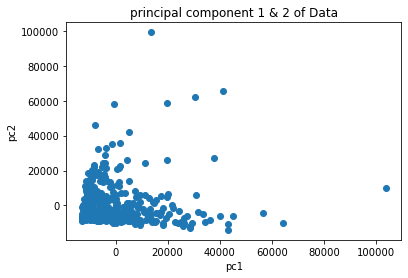

In [17]:
# 散布図確認
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.title('principal component 1 & 2 of Data')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


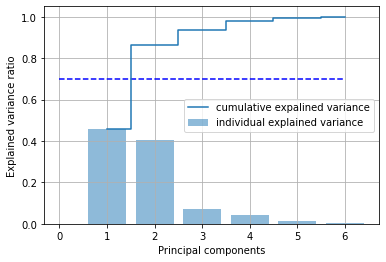

In [18]:
# 分散説明率
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

- 主成分の上位2つで、全体の分散の約86%が反映されている

### 【問題10】クラスタ数$k$の選択  
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [19]:
# 次元削減されたデータの学習
skm = ScratchKMeans(n_clusters=5, 
                    n_init=2, 
                    max_iter=5, 
                    tol=1e-5,
                    verbose=False)
skm.fit(data_pca)

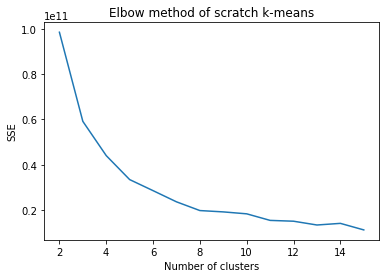

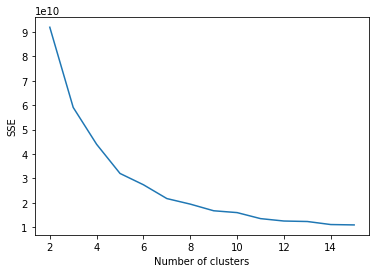

In [20]:
# エルボー法
elbow_view(data_pca, n_clusters=15, max_iter=10, title='Elbow method of scratch k-means')
elbow_view(data_pca, n_clusters=15, max_iter=50, title=None)

< Silhouette view of scratch k-means>
< 2 clusters >


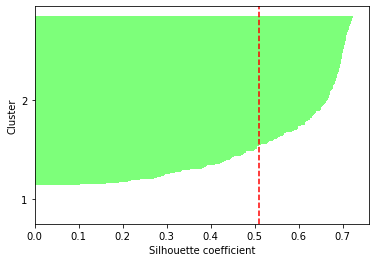

< 3 clusters >


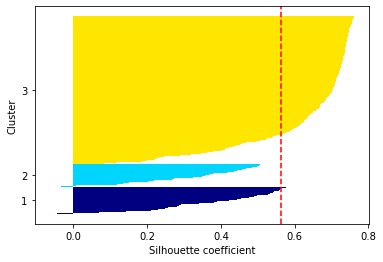

< 4 clusters >


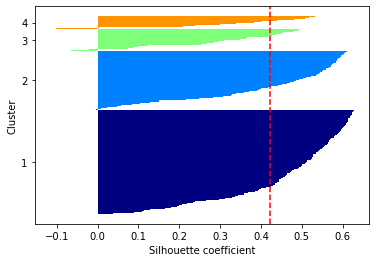

< 5 clusters >


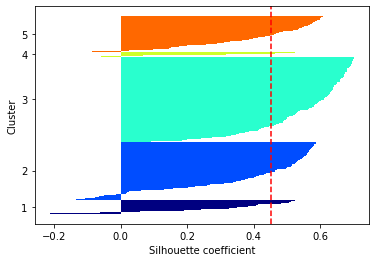

< 6 clusters >


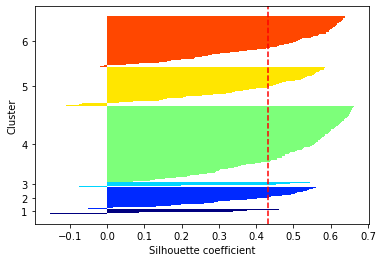

< 7 clusters >


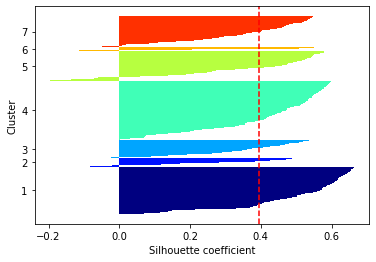

< 8 clusters >


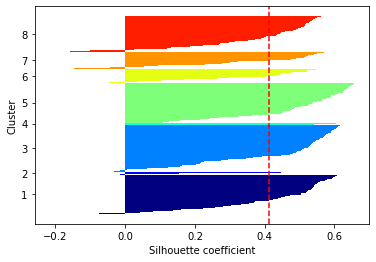

< 9 clusters >


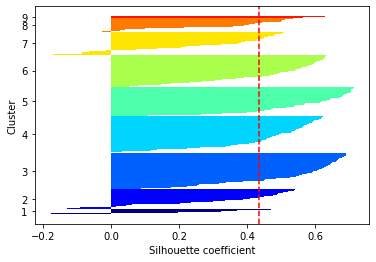

< 10 clusters >


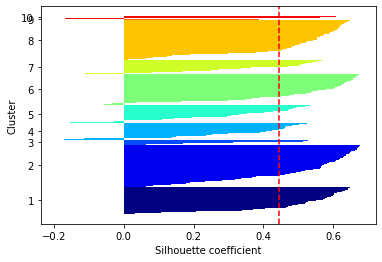

In [21]:
# シルエット図
print('< Silhouette view of scratch k-means>')
silhouette_view(data_pca, n_clusters=10, max_iter=10)

- エルボー法にてiterationを変えてみたが、結果は変わらないようだ
- 微妙な判断だが、エルボー法・シルエット図からはクラス数 10 前後が適切か  


- 元の散布図を見ると0付近にサンプルが集中しているため、最小値を正の値に修正した上で対数をとってみることにする

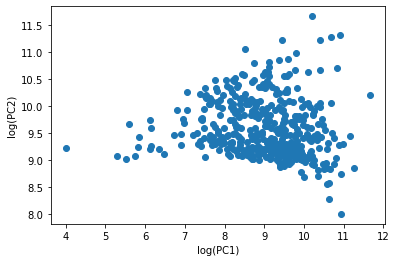

In [22]:
# 次元削減後のデータの対数化
p1_min, p2_min = np.abs(np.amin(data_pca, axis=0))
# 最小値を0にした後、適当な値を加える
data_pca_p1 = data_pca[:, 0] + p1_min + np.exp(4)
data_pca_p2 = data_pca[:, 1] + p2_min + np.exp(8)
data_pca_p = np.vstack([data_pca_p1, data_pca_p2]).T
log_data_pca = np.log(data_pca_p)

# 散布図の描画
plt.scatter(log_data_pca[:,0], log_data_pca[:,1])
plt.xlabel('log(PC1)')
plt.ylabel('log(PC2)')
plt.show()

In [23]:
skm = ScratchKMeans(n_clusters=5, 
                    n_init=2, 
                    max_iter=5, 
                    tol=1e-5,
                    verbose=False)
skm.fit(log_data_pca)

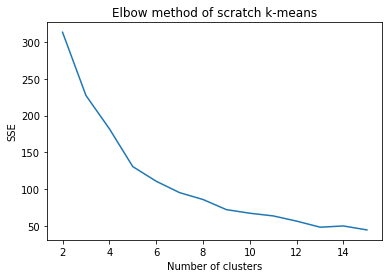

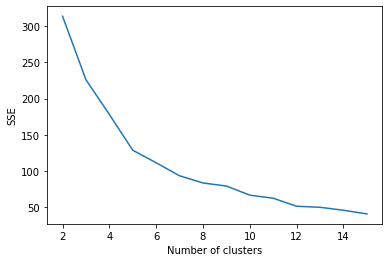

In [24]:
# エルボー法
elbow_view(log_data_pca, n_clusters=15, max_iter=10, title='Elbow method of scratch k-means')
elbow_view(log_data_pca, n_clusters=15, max_iter=50, title=None)

< Silhouette view of scratch k-means>
< 2 clusters >


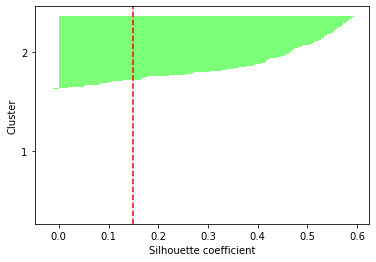

< 3 clusters >


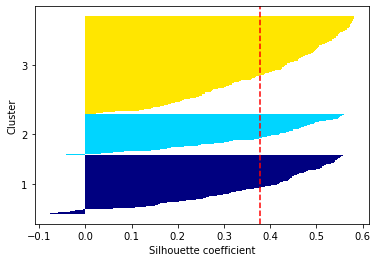

< 4 clusters >


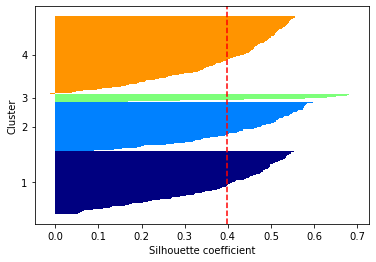

< 5 clusters >


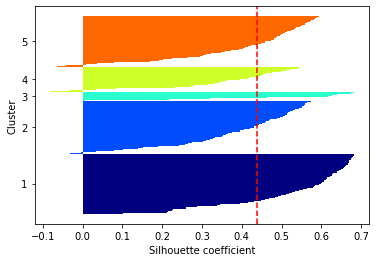

< 6 clusters >


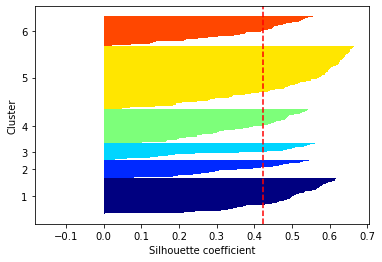

< 7 clusters >


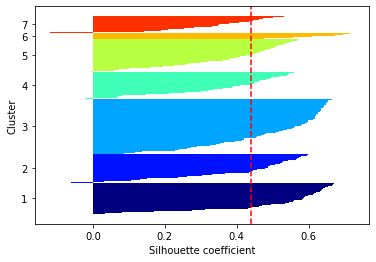

< 8 clusters >


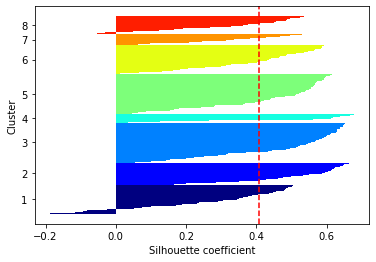

< 9 clusters >


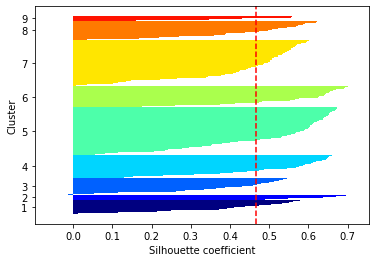

< 10 clusters >


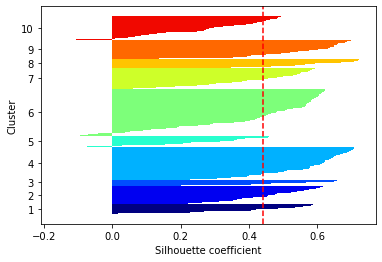

In [25]:
# シルエット図
print('< Silhouette view of scratch k-means>')
silhouette_view(log_data_pca, n_clusters=10, max_iter=10)

- 対数化してみても、結果には大差ないようだ

### ＜既知のグループとの比較＞  
``Region``と``Channel``はK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [26]:
df_1 = df.iloc[:, 0]
df_2 = df.iloc[:, 1]
display(df_1.value_counts())
display(df_2.value_counts())

1    298
2    142
Name: Channel, dtype: int64

3    316
1     77
2     47
Name: Region, dtype: int64

- Channel : 2 ×Resion : 3で計6通りの集団がある

In [27]:
# k-meansで5epoc繰り返し、SSEが最小のものを選択する
skm = ScratchKMeans(n_clusters=10, 
                    n_init=5, 
                    max_iter=10, 
                    tol=1e-5,
                    verbose=False)
skm.fit(data_pca)
skm.SSEs

[19514945164.392754,
 15872403294.111996,
 19549294891.849113,
 17740984020.503212,
 20141646891.204533]

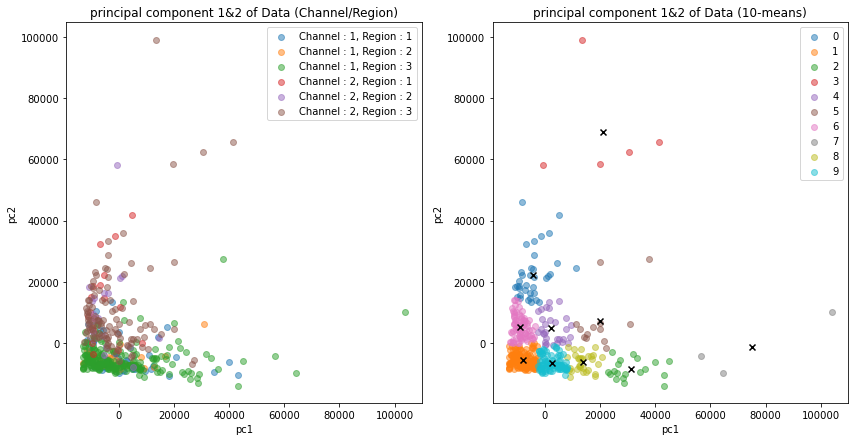

In [28]:
# 学習クラスタと、既知クラスタとの比較

# 既知クラスタの散布図
cr = df.iloc[:, :2].values
data_cr = np.hstack([cr, data_pca])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
for i in range(1, 3):
    for j in range(1, 4):
        data_ij = data_pca[np.where((cr[:, 0]==i)&(cr[:, 1]==j))[0]]
        plt.scatter(data_ij[:, 0], data_ij[:, 1], 
                    label='Channel : {}, Region : {}'. format(i, j),
                    alpha=0.5)
plt.title("principal component 1&2 of Data (Channel/Region)")
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend()

# 学習クラスタの散布図（SSEが最小のepoc:2を用いる）
mu, R = skm.predict(data_pca, epoc=2)
plt.subplot(1,2,2)
for i in range(mu.shape[0]):
    data_pca_i = data_pca[R[:, i]==1]
    plt.scatter(data_pca_i[:, 0], data_pca_i[:, 1], label=i, alpha=0.5)
for j in range(mu.shape[0]):
    plt.scatter(mu[j, 0], mu[j, 1], color='black', marker='x')
plt.title("principal component 1&2 of Data (10-means)")
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend()

plt.show()

- 既知のクラスタは、必ずしもある重心を平均とした正規分布に従っているわけではなさそう
- 対してk-meansでは、ある重心からの距離でクラスタを割り当てるため、両者のクラスタは大きく異なっている　  　

→対数化したデータでも試してみる

In [29]:
# 対数化データをk-meansで5epoc繰り返し、SSEが最小のものを選択する
skm = ScratchKMeans(n_clusters=10, 
                    n_init=5, 
                    max_iter=10, 
                    tol=1e-5,
                    verbose=False)
skm.fit(log_data_pca)
skm.SSEs

[66.85231196923044,
 73.63373927868304,
 71.51337590668163,
 66.96505688657325,
 68.82002953834103]

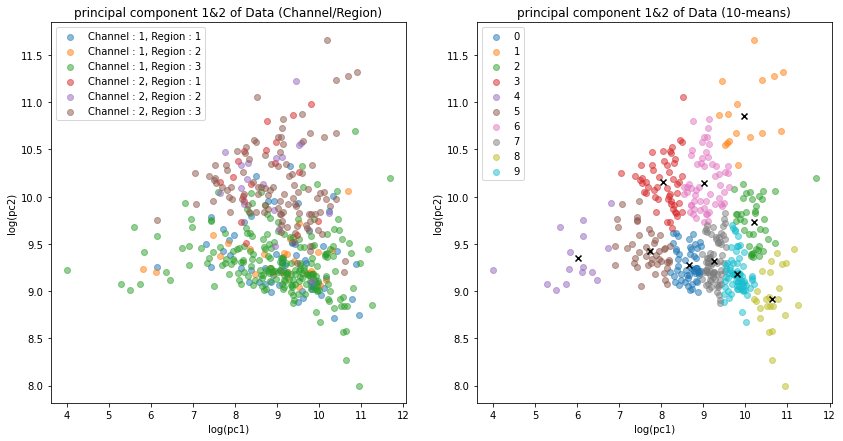

In [30]:
# 学習クラスタと、既知クラスタとの比較(対数化)

# 既知クラスタの散布図
cr = df.iloc[:, :2].values
data_cr = np.hstack([cr, log_data_pca])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
for i in range(1, 3):
    for j in range(1, 4):
        data_ij = log_data_pca[np.where((cr[:, 0]==i)&(cr[:, 1]==j))[0]]
        plt.scatter(data_ij[:, 0], data_ij[:, 1], 
                    label='Channel : {}, Region : {}'. format(i, j),
                    alpha=0.5)
plt.title("principal component 1&2 of Data (Channel/Region)")
plt.xlabel('log(pc1)')
plt.ylabel('log(pc2)')
plt.legend()

# 学習クラスタの散布図（SSEが最小のepoc:1を用いる）
mu, R = skm.predict(log_data_pca, epoc=1)
plt.subplot(1,2,2)
for i in range(mu.shape[0]):
    data_i = log_data_pca[R[:, i]==1]
    plt.scatter(data_i[:, 0], data_i[:, 1], label=i, alpha=0.5)
for j in range(mu.shape[0]):
    plt.scatter(mu[j, 0], mu[j, 1], color='black', marker='x')
plt.title("principal component 1&2 of Data (10-means)")
plt.xlabel('log(pc1)')
plt.ylabel('log(pc2)')
plt.legend()

plt.show()

- 対数化したデータでも、結果は大きく変わらない
- 既知クラスタで、緑と茶や赤とオレンジのクラスタには分布に違いがありそうだ

### 【問題12】卸売業者にとっての有益な情報  
卸売業者にとって有益な情報を探し出し文章にまとめてください。

《ヒント》  
前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。  
条件ごとにデータを見る際にはPandasの``groupby``が便利です。

### ＜方針＞  
既知のクラスタと比較し、k-meansでは意味のあるクラスタリングができているとは考えにくい。  
よって、既知のクラスタ間の違いについてのみ検証する。

< Components >


Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

pc1 : [ 0.97653685  0.12118407  0.06154039  0.15236462 -0.00705417  0.06810471]
pc2 : [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]


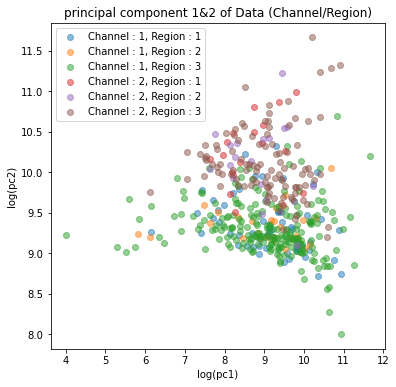

In [31]:
# 対数化データの散布図を再確認
plt.figure(figsize=(6,6))
for i in range(1, 3):
    for j in range(1, 4):
        data_ij = log_data_pca[np.where((cr[:, 0]==i)&(cr[:, 1]==j))[0]]
        plt.scatter(data_ij[:, 0], data_ij[:, 1], 
                    label='Channel : {}, Region : {}'. format(i, j),
                    alpha=0.5)
plt.title("principal component 1&2 of Data (Channel/Region)")
plt.xlabel('log(pc1)')
plt.ylabel('log(pc2)')
plt.legend()

# PCAの成分から考察
print('< Components >')
display(df.iloc[:, 2:].columns)
print('pc1 :', pca.components_[0])
print('pc2 :', pca.components_[1])

### ＜考察①＞  
- 散布図を見ると、Channel/Region : 2/1（赤）、2/2（紫）、2/3（茶）は主成分 2 が大きい傾向にある
- Channel/Region : 1/1（青）は全体的に分布し、1/2（オレンジ）、1/3（緑）は主成分 2 が小さい傾向にある
- 主成分 1 はクラスタ間で違いが少ない
- 主成分 2 の正の成分は1st.'Grocery', 2nd.'Milk'であり、負の成分は1st.'Fresh', 2nd.'Frozen'である  
↓  
これらより、Channelの違いにより消費の傾向が違っている可能性が考えられる。よって卸売業者からみれば、Channel 1には'Fresh'や'Frozen'の品目、Channel 2には'Grocery'や'Milk'の品目を卸していった方が、より大きな利益が見込める可能性がある。

In [32]:
# Channel毎の平均を表示
print('< Means (Channel) >')
display(df.groupby('Channel').mean())

# Region毎の平均を表示
print('< Means (Region) >')
display(df.groupby('Region').mean())

< Means (Channel) >


,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


< Means (Region) >


,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,1.233766,11101.727273,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
2,1.404255,9887.680851,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
3,1.332278,12533.471519,5977.085443,7896.363924,2944.594937,2817.753165,1620.601266


### ＜考察②＞  
- やはりChannelの違いにより消費品目の違いが出ており、'Fresh'や'Frozen'はChanel 1 の方が消費額が大きい
- 特記すべきこととして、Detergents/Paperの消費傾向が最も違いが大きく、卸売業者にとって重要な情報である  
- Region間では特記すべき相違は見いだせない  
↓  
主成分分析は特徴量の線形結合で新たな主成分を生成するので、rangeの大きい特徴量の影響が大きく出てしまうものと推察される。  
よって各特徴量を標準化した後に主成分分析を行った方が、後の成分分析にとって有用であると思われる。  
また成分分析はデータ分析の手がかりとして使用し、得られた推察のもとで次元削減前の統計量を確認することが重要と考えられる。

### ＜他の非階層クラスタリング手法＞  
### 【問題13】他の手法の調査  
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。
- DBSCANのメリット・デメリット
- t-SNE、LLEのメリット・デメリット
について記述してください。

### ＜DBSCAN＞
1. 概要  
DBSCAN（Density-based Spatial Clustering of Applications with Noise）は、密度ベースのクラスタリング手法である。半径εと個数MinPtsを指定し、半径ε以内にMinPts以上の隣接点を持つ点を**コア点**、上記を満たさないがコア点の半径ε以内に位置する点を**ボーダー点**、それ以外を**ノイズ点**とみなす。各ボーダー点を、それと対いなっているコア点のクラスに割り当てている。
  
  
2. メリット  
・クラス数を指定する必要がない  
・「クラスが球状である」事を前提とするk-meansと異なり、球状以外の形状を識別できる  
・ノイズ点を除去することができる  
  
  
3. デメリット  
・2つのハイパーパラメーター（ε, MinPts）の調整が難しい  
・他のクラスタリング手法と同様、**次元の呪い**の効果を受ける

### ＜t-SNE＞
1. 概要  
t分布型確率的近傍埋め込み法 t-SNE（t-distributed Stochastic Neighbor Embedding）は、非線形次元削減手法のひとつ。高次元のデータ集合を2次元または3次元へ配置する際に、高い確率で類似した集合が近傍に、異なる集合が遠方となるように対応付ける。具体的には，(1)高次元空間上の類似度 と (2)低次元空間上の類似度 をそれぞれ確率分布$p_{ij}$と$q_{ij}$で表現し、これらを最小化するように確率分布のパラメータを最適化する。
t-SNEの以前にSNEという手法があり、SNEでは$p$, $q$ともに正規分布でモデル化していた。対して、t-SNEは1. $p_{ij}$, $q_{ij}$を同時確率に変更、2. $q_{ij}$をt-分布でモデル化 することにより、最適化を容易にしているらしい。
  
  
2. メリット  
・高次元空間での非線形構造を持つデータを、適切に低次元表現できる  
（PCAはデータが多次元正規分布に従うことを仮定しており、高次元空間での非線形構造をうまく低次元表現できない）
  
  
3. デメリット  
・2ないし3次元への圧縮しかうまくいかない  
・局所構造が次元の呪いに敏感  
・最適化の収束性が保証されていない

### ＜LLE＞
1. 概要  
局所線形埋め込み法 LLE（Locally-Linear Embedding）は、多様体学習の考えを用いた高次元空間に非線形構造をもつデータの次元削減法のひとつ。多様体とは、局所的にみれば線形空間で表すことのできる構造のことで、swiss rollなどが有名。LEEの概念としては、とあるサンプル$x$が近傍のサンプルの線形結合で表せる、つまり多様体であることを要請し、この局所的な位置関係を保存したまま低次元の空間に射影している、らしい。
  
2. メリット  
・多様体構造を持つデータを、適切に低次元表現できる
  
  
3. デメリット  
・多様体が複数ある場合は、互いの位置関係がうまく保存されない  
・圧縮後のデータ位置を再構成する計算量がデータ数の2乗に比例するため、大規模なデータに適用しづらい

< Swiss Roll >


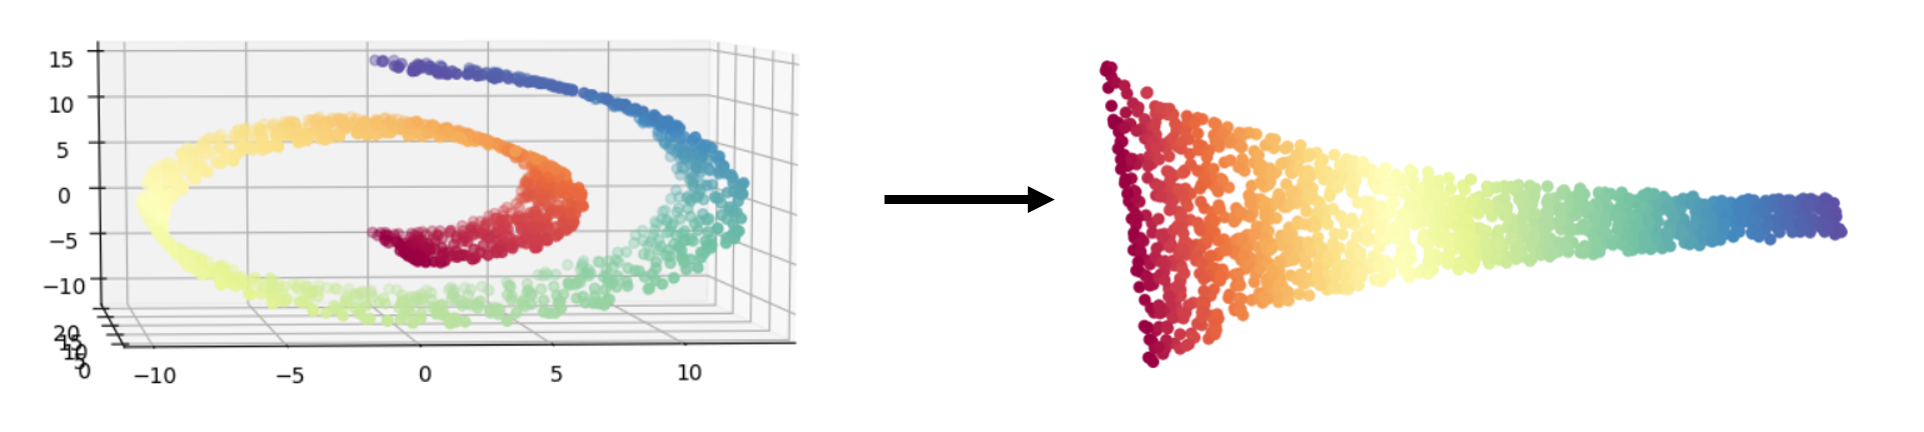

In [33]:
print('< Swiss Roll >')
Image("7-1.png")

### 【問題14】t-SNEとDBSCANの利用    
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。  
そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。  

**《パラメーターチューニング》**  
これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

In [34]:
# t-SNEにて次元削減
tsne = TSNE(n_components = 2)
data_tsne = tsne.fit_transform(data)
data_tsne[:5]

array([[ -3.6705413 ,  -1.9635416 ],
       [  0.96238035, -11.980896  ],
       [  5.40325   , -10.32576   ],
       [  6.4997463 ,  16.178793  ],
       [-14.913254  ,  10.133032  ]], dtype=float32)

< t-SNE data >


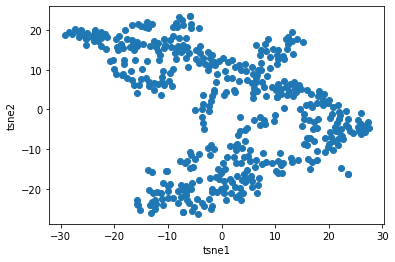

In [35]:
# 散布図の確認
print('< t-SNE data >')
plt.scatter(data_tsne[:,0], data_tsne[:,1])
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

In [36]:
# DBSCANにてクラスタリング
dbscan = DBSCAN(eps=2, min_samples=2)
labels = dbscan.fit_predict(data_tsne)
cluster, count = np.unique(labels, return_counts=True)
print('cluster :', cluster)
print('count :', count)

cluster : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
count : [ 10   3 115 221  14   7  25   3   2   9   4   4  11   5   2   2   3]


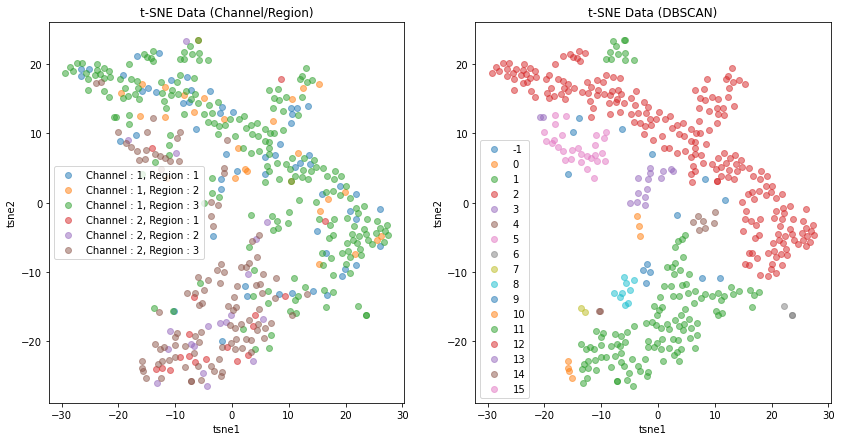

In [37]:
# 学習クラスタと既知クラスタとの比較

# 既知クラスタの散布図
cr = df.iloc[:, :2].values
data_cr = np.hstack([cr, data_tsne])

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
for i in range(1, 3):
    for j in range(1, 4):
        data_ij = data_tsne[np.where((cr[:, 0]==i)&(cr[:, 1]==j))[0]]
        plt.scatter(data_ij[:, 0], data_ij[:, 1], 
                    label='Channel : {}, Region : {}'. format(i, j),
                    alpha=0.5)
plt.title("t-SNE Data (Channel/Region)")
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 


# 学習クラスタの散布図
plt.subplot(1,2,2)
for i in range(len(cluster)):
    data_i = data_tsne[np.where(labels==cluster[i])[0]]
    plt.scatter(data_i[:, 0], data_i[:, 1], label=cluster[i], alpha=0.5)
plt.title("t-SNE Data (DBSCAN)")
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

- PCA + K-meansではChannel/Region : 1/3（緑）と2/3（茶）の分別も難しかったが、t-SNE + DBSCANでは少なくともこれらの分別ができているようだ
- t-SNEによりこれらのクラスタがより離れた位置に配置され、DBSCANにより球状ではなく細長い1/3（緑、DBSCANでは赤）も同じクラスタとして認識できているようだ
- パラメータの調節次第では、その他のクラスタも分別可能にできるかもしれない